# KSKL

In [1]:
import sys
sys.path.append('../notebooks/')

In [2]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from glob import glob

import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [9]:
def calc_cs_born(df):
    cs_born = df['n_sig_exp']/(df['lum']*df['eff0']*df['eff_trig']*df['rad']*df['dccorr'])
    cs_born_err = cs_born*df['rad']*np.sqrt( (df['n_sig_exp_err']/df['n_sig_exp'])**2 +
        (df['lum_err']/df['lum'])**2 + (df['eff0_err']/df['eff0'])**2 + (df['eff_trig_err']/df['eff_trig'])**2 + 
                                           (df['dccorr_err']/df['dccorr'])**2) #не делю на рад.поправку
    return (cs_born, cs_born_err)
def get_cs(season, dropna=False):
    df_signal = pd.read_csv(f'../data/{season}/results/signal.csv', index_col=0)
    df_reg_eff = pd.read_csv(f'../data/{season}/results/reg_eff.csv', index_col=0)
    df_triggers = pd.read_csv(f'../data/{season}/results/triggers.csv', index_col=0)
    df_lum = pd.read_csv(f'/storeA/ryzhenenkov/lum20{season}.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy')
    df_dc = pd.read_csv(f'../data/{season}/results/dc_n2.csv', index_col=0) \
        if os.path.isfile(f'../data/{season}/results/dc_n2.csv') else pd.DataFrame({'dccorr': 1, 'dccorr_err': 0}, index=df_signal.index)
    df_rads = pd.read_csv(f'../data/{season}/results/radcors.csv', index_col=0) \
        if os.path.isfile(f'../data/{season}/results/radcors.csv') else pd.DataFrame({'rad': 1, 'rad_err': 0}, index=df_signal.index)
    df = pd.concat([df_signal, df_reg_eff, df_triggers, df_lum, df_dc, df_rads], axis=1)
    df.rad.fillna(1, inplace=True)
    df.rad_err.fillna(0, inplace=True)
    df['cs_born'], df['cs_born_err'] = calc_cs_born(df)
    df['season'] = season
    if dropna:
        df.dropna(inplace=True)
    return df

In [10]:
crosses = {
    '11': get_cs('11'),
    '12': get_cs('12'),
    '17': get_cs('17'),
    '19': get_cs('19'),
    '20': get_cs('20'),
}

1. Фит теперь не по инв массе, а по оси корреляции

In [9]:
SEASON = '12'
exp_tree = uproot.open(f'../trees/{SEASON}/exp.root')['t']
mc_tree = uproot.open(f'../trees/{SEASON}/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=False, z_cut=None)
df_mc = preprocess.read_tree(mc_tree, mc=True, z_cut=None)

In [10]:
energy = 800

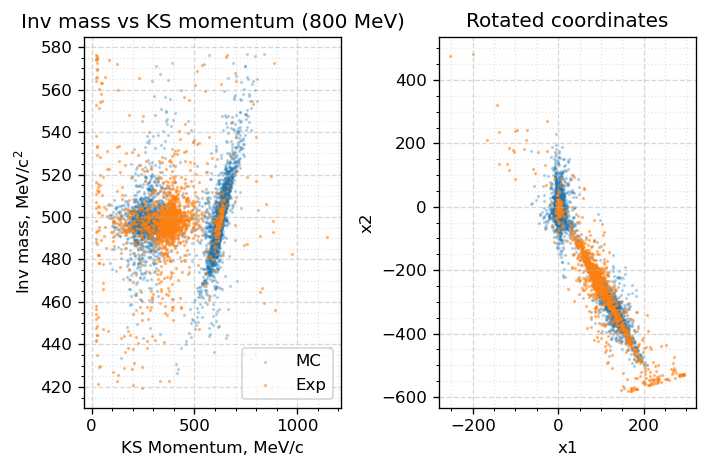

In [11]:
df_temp_exp, df_temp_mc = df_exp.loc[energy], df_mc.loc[energy]

plt.subplot(121)
plt.scatter(df_temp_mc.ksptot, df_temp_mc.ksminv, s=1, alpha=0.25, label='MC')
plt.scatter(df_temp_exp.ksptot, df_temp_exp.ksminv, s=1, alpha=0.45, label='Exp')
pys.my_style(f'Inv mass vs KS momentum ({energy} MeV)', legend=True,
             xtitle='KS Momentum, MeV/c', ytitle='Inv mass, MeV/c${}^2$');

plt.subplot(122)
plt.scatter(df_temp_mc.x1, df_temp_mc.x2, s=1, alpha=0.25, label='MC')
plt.scatter(df_temp_exp.x1, df_temp_exp.x2, s=1, alpha=0.45, label='Exp')
pys.my_style('Rotated coordinates', xtitle='x1', ytitle='x2');

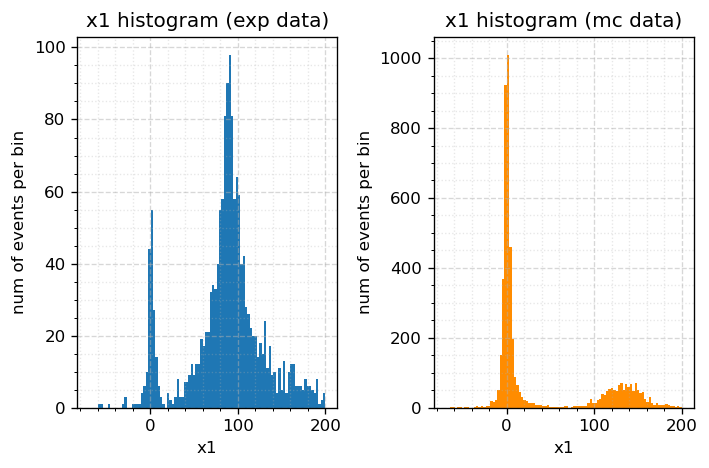

In [8]:
hist_range = (-70, 200)

plt.subplot(121)
plt.hist(df_temp_exp.x1, bins=100, range=hist_range);
pys.my_style('x1 histogram (exp data)', 
             xtitle='x1', ytitle='num of events per bin');

plt.subplot(122)
plt.hist(df_temp_mc.x1, bins=100, range=hist_range, color='darkorange');
pys.my_style('x1 histogram (mc data)', 
             xtitle='x1', ytitle='num of events per bin');

2. Посмотрел на `multihadrons`
![](./sources/study/multics.png)


* доминирующие фоны на разных энергиях????

* нет пучкового фона: посмотреть на распределения без ката на z

* подгонять распределения из мультиадронного генератора

3. Новая фит-функция

![](./sources/study/cruijff.png)

$p = N_{sig} \cdot f(x; m_0, ...) + N_{bkg} \cdot ( kx + b )$

$\int_{x_{min}}^{x_{max}}(kx+b)dx = 1$

![](./sources/study/exp17_880.png)
![](./sources/study/mc17_880.png )

4. Эффективность регистрации, радпоправка и триггеры

z > 12 см![](./sources/study/regeff17.png )

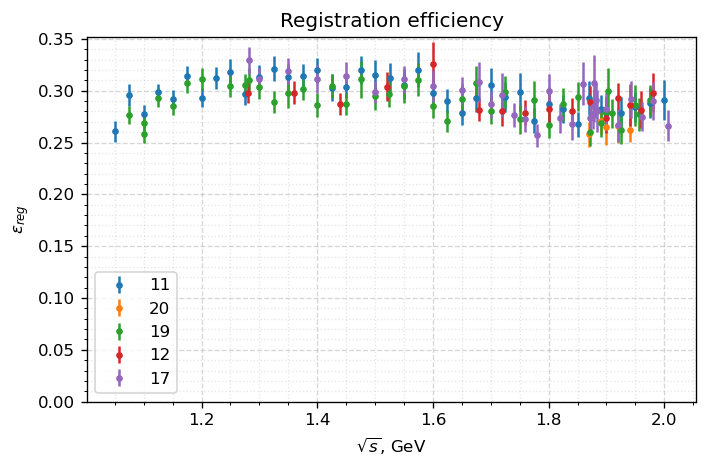

In [9]:
dfs_reg = {re.findall(r'data/(.*)/results', i)[0] : pd.read_csv(i, index_col=0) for i in glob('../data/*/results/reg_eff.csv')}
for key in dfs_reg:
    plt.errorbar(dfs_reg[key].index*2e-3, dfs_reg[key].eff0, 
                 yerr=dfs_reg[key].eff0_err, fmt='.', label=key)
pys.my_style('Registration efficiency', xtitle='$\\sqrt{s}$, GeV', ytitle='$\\varepsilon_{reg}$', legend=True,
            ylim=(0, None))

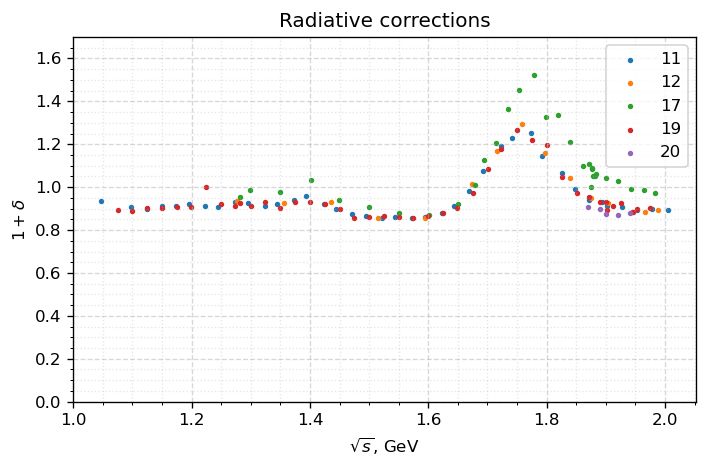

In [18]:
for k in crosses:
    plt.scatter(crosses[k]['emeas']*2e-3, crosses[k]['rad'], s=5, label=k)
pys.my_style('Radiative corrections', legend=True, xtitle='$\sqrt{s}$, GeV',
            ytitle='$1+\delta$', ylim=(0, 1.7))

5. Поправка на ДК

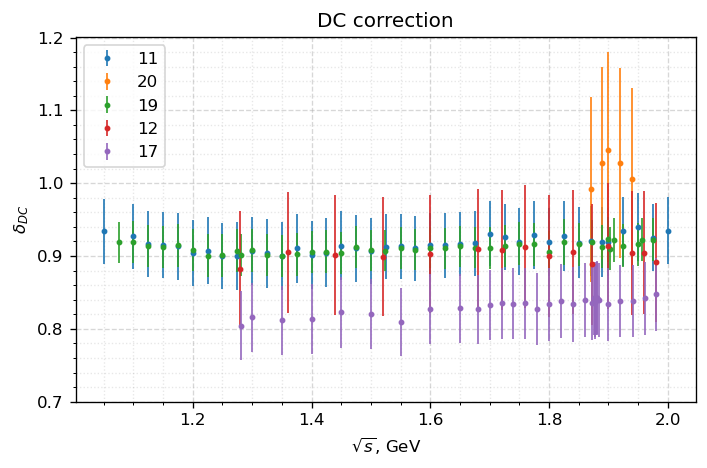

In [7]:
dfs_reg = {re.findall(r'data/(.*)/results', i)[0] : pd.read_csv(i, index_col=0) for i in glob('../data/*/results/dc_n2.csv')}
for key in dfs_reg:
    plt.errorbar(dfs_reg[key].index*2e-3, dfs_reg[key].dccorr, 
                 yerr=dfs_reg[key].dccorr_err, fmt='.', label=key, ms=5, lw=1)
pys.my_style('DC correction', xtitle='$\\sqrt{s}$, GeV', ytitle='$\\delta_{DC}$', legend=True,
            ylim=(0.7, None))

6. Сечения

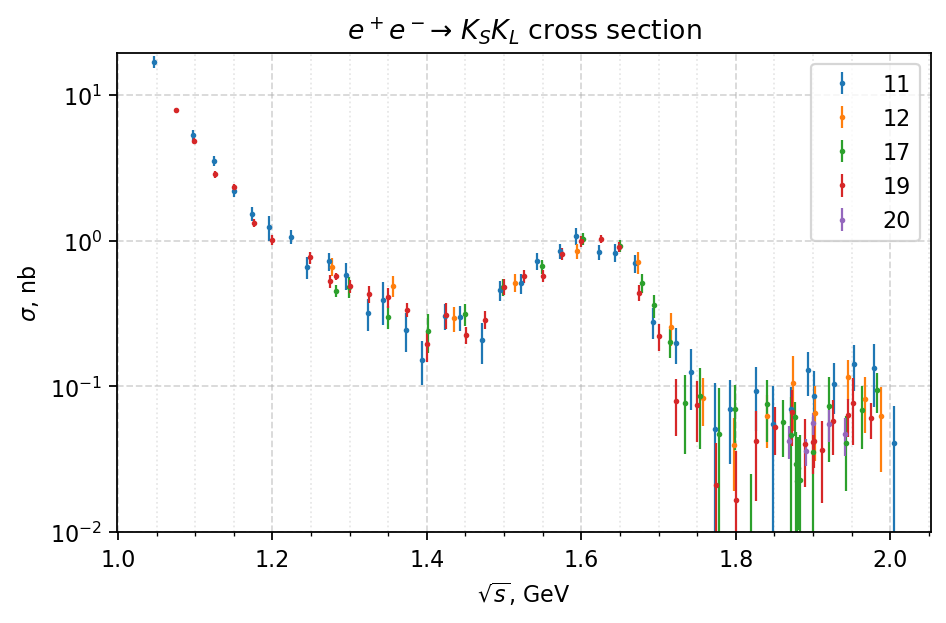

In [11]:
fig, ax = plt.subplots(dpi=160)
for cs in crosses:
    ax.errorbar(crosses[cs].emeas*2e-3, crosses[cs].cs_born, yerr=crosses[cs].cs_born_err, fmt='.', label=cs, ms=3, lw=1)
pys.my_style(title='$e^+e^- \\to \ K_SK_L$ cross section', xtitle='$\sqrt{s}$, GeV', ytitle='$\sigma$, nb', ylim=(1e-2, None), legend=True)
ax.set_yscale('symlog', linthresh=1e-3) 

## New

680Сравнение сечений на фи-мезоне

![](./sources/study/cs_diffs.png)

* Посмотрел $4 \gamma$
* Исправил неоправданно низкие ошибки в фите

#### Пучковый фон

смотрю на распределение по `x1` для событий с треками, чей `z > 12 см`

In [12]:
df_exp.index.unique()

Float64Index([640.0, 680.0, 720.0, 760.0, 800.0, 840.0, 860.0, 880.0, 900.0,
              920.0, 936.0, 950.0, 960.0, 970.0, 980.0, 990.0],
             dtype='float64', name='ebeam')

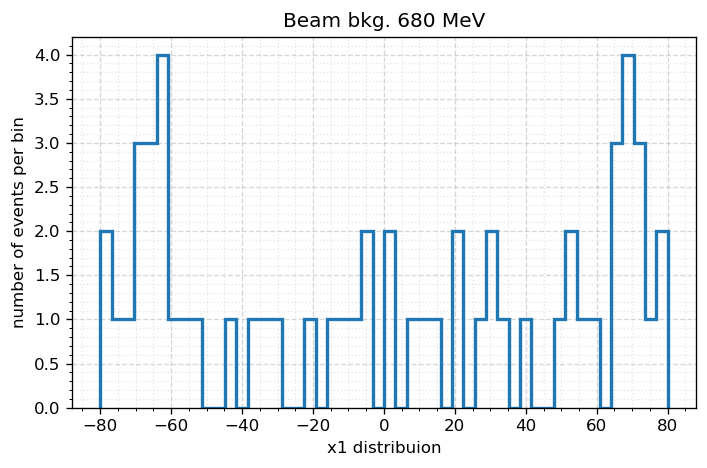

In [12]:
e = 680
plt.hist( df_exp.loc[(np.abs(df_exp['tz[0]']) > 12) | (np.abs(df_exp['tz[1]']) > 12)].loc[640].x1, bins=50, range=(-80, 80), histtype='step', lw=2)
pys.my_style(f'Beam bkg. {e} MeV', 'x1 distribuion', 'number of events per bin')

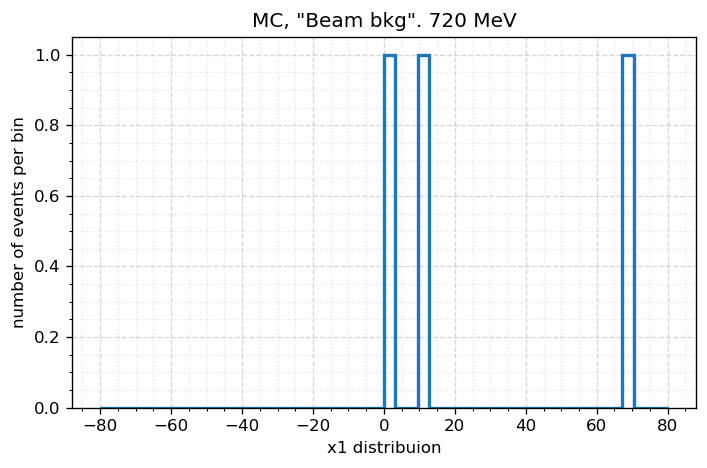

In [14]:
e = 720
plt.hist( df_mc.loc[(np.abs(df_mc['tz[0]']) > 12) | (np.abs(df_mc['tz[1]']) > 12)].loc[e].x1, bins=50, range=(-80, 80), histtype='step', lw=2)
pys.my_style(f'MC, "Beam bkg". {e} MeV', 'x1 distribuion', 'number of events per bin')

#### Поправка ДК

$$ \sigma_{born} = \frac{N}{L \varepsilon (1+\delta)}, \sigma_{vis} = \frac{N}{L} $$
$$ \varepsilon = \varepsilon_{reg} \cdot \varepsilon_{trig} \cdot \frac{\varepsilon_{DC}^{MC}}{\varepsilon_{DC}^{exp}} = \varepsilon_{reg} \cdot \varepsilon_{trig} \cdot (1+ \delta_{DC}) $$

$$ \sigma_{vis} = \int_x \sigma_{born}(x, s) F(x, s) \varepsilon_{reg}(x, s) [1 + \delta_{DC}(x,s)] dx $$

Раньше, когда не было поправки на ДК:
$$ \varepsilon_{reg}(s) = \frac{\int_x \sigma_{born}(x,s) F(x,s) \varepsilon_{reg}(x, s) dx}{ \int_x \sigma_{born}(x,s) F(x, s) dx } = \frac{N^{passed}_{MC}}{N^{total}_{MC}} $$

Теперь, по аналогии:
$$ \varepsilon_{reg}(s) \cdot (1 + \delta_{DC}) = \frac{\int_x \sigma_{born}(x,s) F(x,s) \varepsilon_{reg}(x, s) (1 + \delta_{DC}(x,s)) dx}{ \int_x \sigma_{born}(x,s) F(x, s) dx } = \frac{\bar{N}^{passed}_{MC}}{N^{total}_{MC}} $$

т.е. если я перевзвешу события в моделировании и найду количество событий прошедших отборы, то получу $\varepsilon_{reg}(s) (1 + \delta_{DC})$

но с другой стороны, я могу свести задачу к предыдущей

$$ (1 + \delta_{DC}) = \frac{\int_x \sigma_{born}(x,s) F(x,s) \varepsilon_{reg}(x, s) (1 + \delta_{DC}(x,s)) dx}{ \int_x \sigma_{born}(x,s) F(x,s) \varepsilon_{reg}(x, s) dx} = \frac{\sigma_{vis}(s)}{\int_x \sigma_{born}(x,s) F(x,s) \varepsilon_{reg}(x, s) dx} $$

$$ (1 + \delta_{DC}) = \frac{\bar{N}^{passed}_{MC} \cdot N^{total}_{MC}}{N^{total}_{MC} \cdot N^{passed}_{MC}} = \frac{\sum_{0}^{N_{passed}}w_i}{\sum_{0}^{N_{passed}} 1} $$


#### Проверка гипотезы о независимости поправки на дк

In [106]:
SEASON = '11'
exp_tree = uproot.open(f'../trees/{SEASON}/exp.root')['t']
mc_tree = uproot.open(f'../trees/{SEASON}/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=False, z_cut=12)
df_mc = preprocess.read_tree(mc_tree, mc=True, z_cut=12)

In [107]:
de, dm = df_exp.query('x1>-40&x1<20').copy(), df_mc.query('x1>-40&x1<20').copy()

In [108]:
indexes = de.index.unique().intersection(dm.index.unique())

In [109]:
len_goods = lambda th: len(th[np.abs(th-np.pi/2) < 0.2])
th_exp, th_mc, mm_exp, mm_mc, w = [np.array([]) for _ in range(5)]
for e in indexes:
    th_e = np.concatenate((de.loc[e]['tth[0]'], de.loc[e]['tth[1]']))
    th_m = np.concatenate((dm.loc[e]['tth[0]'], dm.loc[e]['tth[1]']))
    mm_e = np.concatenate((de.loc[e]['tptot[0]'], de.loc[e]['tptot[1]']))
    mm_m = np.concatenate((dm.loc[e]['tptot[0]'], dm.loc[e]['tptot[1]']))
    weight = len_goods(th_e)/len_goods(th_m)
    th_exp = np.append(th_exp, th_e)
    th_mc = np.append(th_mc, th_m)
    mm_exp = np.append(mm_exp, mm_e)
    mm_mc = np.append(mm_mc, mm_m)
    w = np.append(w, np.ones_like(th_m)*weight)

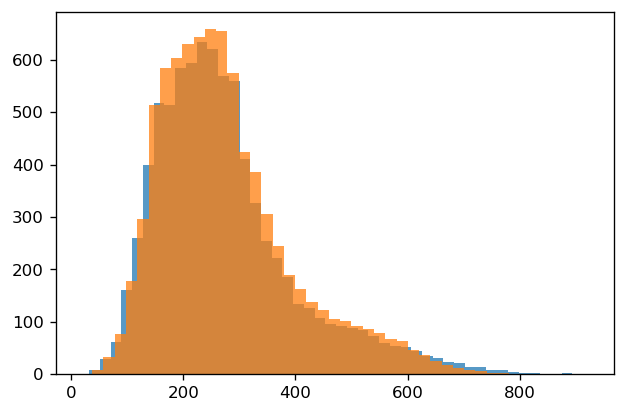

In [110]:
plt.hist(mm_exp, bins=45, alpha=0.75);
plt.hist(mm_mc, bins=45, weights=w, alpha=0.75);

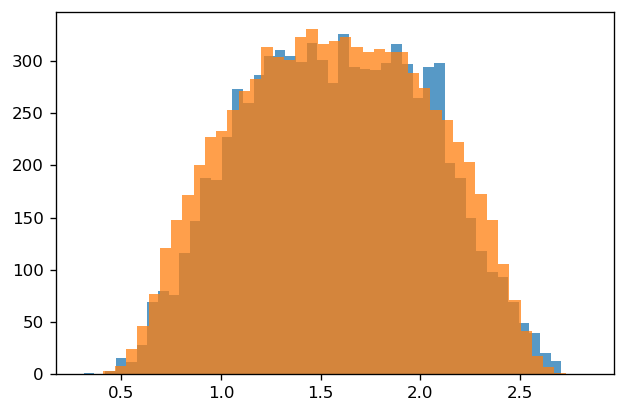

In [111]:
plt.hist(th_exp, bins=45, alpha=0.75);
plt.hist(th_mc, bins=45, weights=w, alpha=0.75);

In [112]:
data_th_exp, bins = np.histogram(th_exp, bins=50, range=(0, np.pi))
data_th_mc, bins = np.histogram(th_mc, bins=50, range=(0, np.pi), weights=w)

/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


(0.0, 2.0)

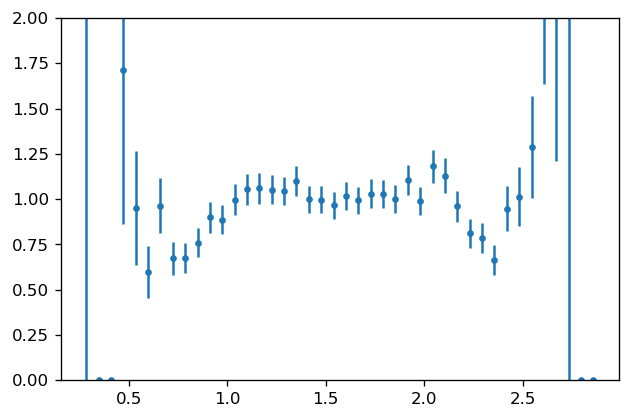

In [113]:
y = data_th_exp/data_th_mc
plt.errorbar((bins[:-1]+bins[1:])/2, y, yerr=y*np.sqrt( 1/data_th_exp + 1/data_th_mc ), fmt='.')
plt.ylim(0, 2)

In [114]:
mm_max = max(np.max(mm_exp), np.max(mm_mc))
data_mm_exp, bins = np.histogram(mm_exp, bins=50, range=(0, mm_max))
data_mm_mc, bins = np.histogram(mm_mc, bins=50, range=(0, mm_max), weights=w)

/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


(0.0, 2.0)

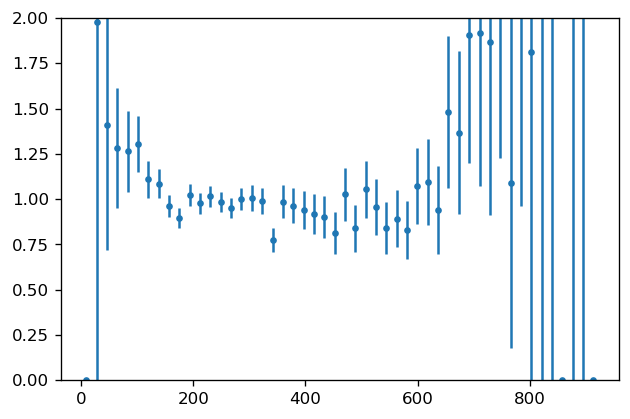

In [115]:
y = data_mm_exp/data_mm_mc
plt.errorbar((bins[:-1]+bins[1:])/2, y, yerr=y*np.sqrt( 1/data_mm_exp + 1/data_mm_mc ), fmt='.')
plt.ylim(0, 2)